In [0]:
!pip install mpnum
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
import tensorflow_probability as tfp
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':24})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)

from google.colab import drive
drive.mount('/content/gdrive')

'''we need to import tf_mpa,
thus, we go to the GAN_for_quantum_data
directory where the file is situated'''
%cd gdrive
%cd My Drive
%cd GAN_for_quantum_data

import tf_mpa
import TFI
import discrete_gan as gan

### Setting of model parameters and initializing of GAN

In [0]:
# number of spins
N = 32

# number of hidden nurons
num_of_h_nurons = 256

# magnetic field
field = 0.9

tf.reset_default_graph()

# initializing of GAN
gan_1 = gan.gan(dim=N, dim_hidden=num_of_h_nurons)

# initializing of sess
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.keras.backend.set_session(sess)

### Uploding of dataset and TFI model

In [0]:
# uploding of dataset
samples = np.load("TFI data/samples_N=" + str(N) + "_h=" + str(round(field, 4)) + ".npy")
file_handler = open("TFI data/model_N=" + str(N) + "_h=" + str(round(field, 4)) + ".obj", 'rb')
tfi_model = pickle.load(file_handler)

### Training

In [0]:
# it will be filled by values of loss
losses_d = []
losses_g = []

# initial and final learning rate of generator
in_lr_g = 0.0001
f_lr_g = 0.0001

# initial and final learning rate of discriminator
in_lr_d = 0.0004
f_lr_d = 0.0004

# initial and final softmax temperature
t_in = 10.
t_f = 0.01

# initial and final smoothing coefficient
eta_in = 1.
eta_f = 0.01

# annealing length of softmax temperature
ann_lenght = 500
ann = (t_f /t_in) ** (1 / ann_lenght)

# annealing length of smoothing
ann_lenght_noise = 500
ann_noise = (eta_f /eta_in) ** (1 / ann_lenght_noise)

# number of epoches
num_of_epochs = 2000

# coefficients of lr annealing
decay_coeff_g = (f_lr_g / in_lr_g) ** (1 / num_of_epochs)
decay_coeff_d = (f_lr_d / in_lr_d) ** (1 / num_of_epochs)

# learning loop
for epoch in range(num_of_epochs):
    
    # it will be filled by values of d and g loss at the current epoch
    l_abs_g = 0
    l_abs_d = 0
    
    # one training step
    l_g, l_d = gan_1.train_epoch(sess=sess, lr_g=in_lr_g, lr_d=in_lr_d,\
                         T=t_in, eta=eta_in, b_size=50000, data=samples)
    
    # update of learning rates
    in_lr_g = in_lr_g * decay_coeff_g
    in_lr_d = in_lr_d * decay_coeff_d
    
    # update of softmax temperature
    if epoch < ann_lenght:
        t_in = t_in * ann
    
    # update of smoothing coefficient
    if epoch < ann_lenght_noise:
        eta_in = eta_in * ann_noise
    
    # ploting loss vs epoches each 10 epoches
    if epoch % 10 == 0:
        
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.plot(losses_d, 'r')
        plt.plot(losses_g, 'b')
        plt.plot(np.log(4) * np.ones((len(losses_d),)), '--r')
        plt.plot(np.log(4) / 2 * np.ones((len(losses_d),)), '--b')
        plt.legend(['d loss', 'g loss'])
        plt.show()
    
    losses_d.append(l_d)
    losses_g.append(l_g)

### Saving of D and G weights

In [0]:
# saving of the weights
g_weights, d_weights = gan_1.get_weights()
np.save("GAN_weights/d_N=" + str(N) + "_h=" + str(round(field, 4)) + ".npy", d_weights)
np.save("GAN_weights/g_N=" + str(N) + "_h=" + str(round(field, 4)) + ".npy", g_weights)

### Loding of D and G weights

In [0]:
d_weights = np.load("GAN_weights/d_N=" + str(N) + "_h=" + str(round(field, 4)) + ".npy", allow_pickle=True)
g_weights = np.load("GAN_weights/g_N=" + str(N) + "_h=" + str(round(field, 4)) + ".npy", allow_pickle=True)
gan_1.set_weights(g_weights, d_weights)

### Sampling from the GAN

In [0]:
samples_learned = gan_1.sample(300000, sess)

### Plotting

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


"plt.savefig('/content/gdrive/My Drive/corr_func.pdf')"

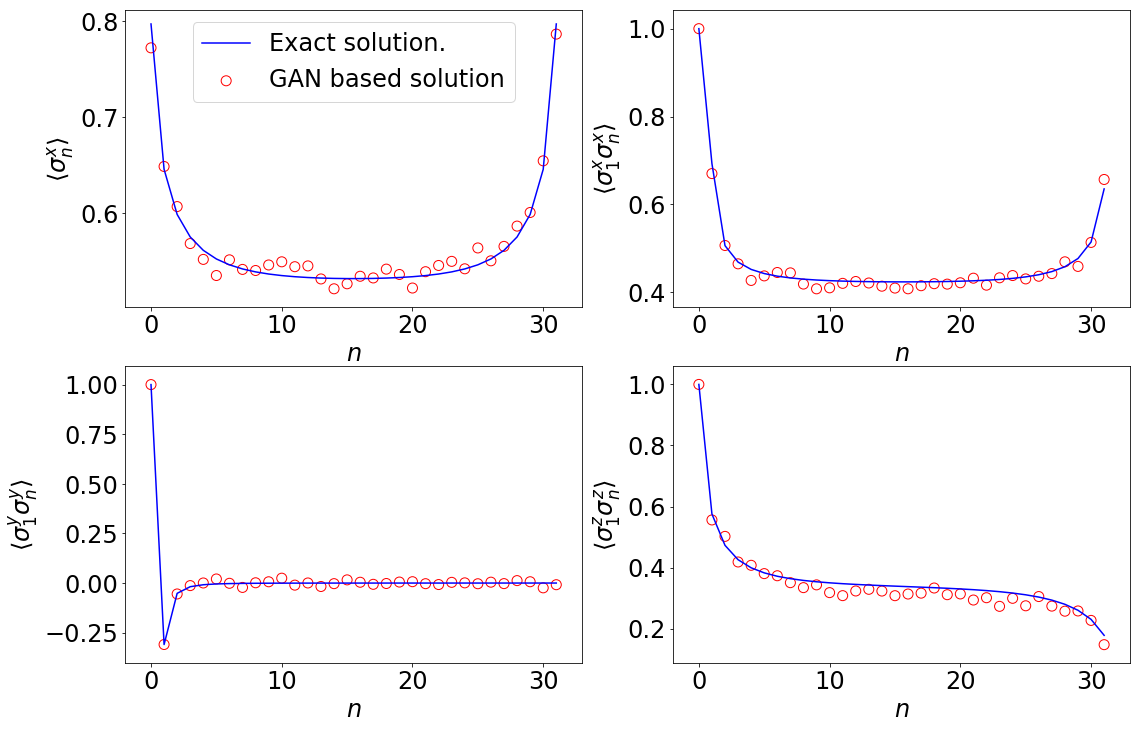

In [53]:
fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_n^{x}\rangle$')
'''plt.ylim(bottom=0)
plt.ylim(top=1)'''
plt.plot([tfi_model.corr(1, i, TFI.idm, TFI.x) for i in range(1, 33)], 'b')
plt.scatter(np.arange(0, 32), [TFI.corr_from_samples(samples_learned, 1, i, TFI.idm, TFI.x) for i in range(1, 33)], s=100, facecolors='none', edgecolors='r')
plt.legend(['Exact solution.', 'GAN based solution'])
'''plt.savefig('/content/gdrive/My Drive/corr_func.pdf')'''

plt.subplot(2, 2, 2)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{x}\sigma_n^{x}\rangle$')
'''plt.ylim(bottom=0)
plt.ylim(top=1)'''
plt.plot([tfi_model.corr(1, i, TFI.x, TFI.x) for i in range(1, 33)], 'b')
plt.scatter(np.arange(0, 32), [TFI.corr_from_samples(samples_learned, 1, i, TFI.x, TFI.x) for i in range(1, 33)], s=100, facecolors='none', edgecolors='r')
'''plt.savefig('/content/gdrive/My Drive/corr_func.pdf')'''

plt.subplot(2, 2, 3)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{y}\sigma_n^{y}\rangle$')
'''plt.ylim(bottom=0)
plt.ylim(top=1)'''
plt.plot([tfi_model.corr(1, i, TFI.y, TFI.y) for i in range(1, 33)], 'b')
plt.scatter(np.arange(0, 32), [TFI.corr_from_samples(samples_learned, 1, i, TFI.y, TFI.y) for i in range(1, 33)], s=100, facecolors='none', edgecolors='r')
'''plt.savefig('/content/gdrive/My Drive/corr_func.pdf')'''

plt.subplot(2, 2, 4)
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
'''plt.ylim(bottom=0)
plt.ylim(top=1)'''
plt.plot([tfi_model.corr(1, i, TFI.z, TFI.z) for i in range(1, 33)], 'b')
plt.scatter(np.arange(0, 32), [TFI.corr_from_samples(samples_learned, 1, i, TFI.z, TFI.z) for i in range(1, 33)], s=100, facecolors='none', edgecolors='r')
'''plt.savefig('/content/gdrive/My Drive/corr_func.pdf')'''